# API data for premier league current season

## Set environment

In [81]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 500)
from datetime import datetime

from dotenv import load_dotenv

import xlsxwriter

import requests
import json

# current date
date = datetime.now().strftime("%Y%m%d")

load_dotenv('../../.env')

True

## API call

### Key columns to keep

In [65]:
# keep columns
keep_cols = [
    'id',
    'utcDate',
    'status',
    'matchday',
    'homeTeam.shortName',
    'awayTeam.shortName',
    'score.winner',
    'score.fullTime.home',
    'score.fullTime.away',
    'score'
]

In [66]:
# Rename club names to simplify
club_names = {
    'Brighton Hove': 'Brighton',
    'Leeds United': 'Leeds',
    'Leicester City': 'Leicester',
    'Wolverhampton': 'Wolves'
}


### API data call

Add scoreline to dataframe

In [67]:
api_key = os.environ['API_AUTH_KEY']
uri = 'http://api.football-data.org/v4/competitions/PL/matches?status=FINISHED'
headers = { 'X-Auth-Token':  api_key}

r = requests.get(uri, headers=headers)
data = r.json()


df = pd.json_normalize(data, record_path='matches')

df['utcDate'] = pd.to_datetime(df['utcDate'])
# sort by date
df = df.sort_values(by='utcDate', ascending=True).reset_index(drop=True)
# rename team names using club_names dict
df['homeTeam.shortName'] = df['homeTeam.shortName'].replace(club_names)
df['awayTeam.shortName'] = df['awayTeam.shortName'].replace(club_names)

# add score column 
df['score'] = df['score.fullTime.home'].astype(str) + '-' + df['score.fullTime.away'].astype(str)

# keep only columns in keep_cols
df = df[keep_cols]

df.head()


,id,utcDate,status,matchday,homeTeam.shortName,awayTeam.shortName,score.winner,score.fullTime.home,score.fullTime.away,score
0,435943,2023-08-11 19:00:00+00:00,FINISHED,1,Burnley,Man City,AWAY_TEAM,0,3,0-3
1,435944,2023-08-12 12:00:00+00:00,FINISHED,1,Arsenal,Nottingham,HOME_TEAM,2,1,2-1
2,435945,2023-08-12 14:00:00+00:00,FINISHED,1,Bournemouth,West Ham,DRAW,1,1,1-1
3,435946,2023-08-12 14:00:00+00:00,FINISHED,1,Brighton,Luton Town,HOME_TEAM,4,1,4-1
4,435947,2023-08-12 14:00:00+00:00,FINISHED,1,Everton,Fulham,AWAY_TEAM,0,1,0-1


In [68]:
# create function to get home_result and away_result
def get_result_home(row):
    if row['score.winner'] == 'HOME_TEAM':
        return 'W'
    elif row['score.winner'] == 'AWAY_TEAM':
        return 'L'
    else:
        return 'D'

def get_result_away(row):
    if row['score.winner'] == 'HOME_TEAM':
        return 'L'
    elif row['score.winner'] == 'AWAY_TEAM':
        return 'W'
    else:
        return 'D'

# apply function to get home_result and away_result
df['home_result'] = df.apply(get_result_home, axis=1)
df['away_result'] = df.apply(get_result_away, axis=1)

df.head()

,id,utcDate,status,matchday,homeTeam.shortName,awayTeam.shortName,score.winner,score.fullTime.home,score.fullTime.away,score,home_result,away_result
0,435943,2023-08-11 19:00:00+00:00,FINISHED,1,Burnley,Man City,AWAY_TEAM,0,3,0-3,L,W
1,435944,2023-08-12 12:00:00+00:00,FINISHED,1,Arsenal,Nottingham,HOME_TEAM,2,1,2-1,W,L
2,435945,2023-08-12 14:00:00+00:00,FINISHED,1,Bournemouth,West Ham,DRAW,1,1,1-1,D,D
3,435946,2023-08-12 14:00:00+00:00,FINISHED,1,Brighton,Luton Town,HOME_TEAM,4,1,4-1,W,L
4,435947,2023-08-12 14:00:00+00:00,FINISHED,1,Everton,Fulham,AWAY_TEAM,0,1,0-1,L,W


In [69]:
# create league table function
def create_league_table(df, homeTeam, awayTeam, home_result, away_result, matchday, team):
    # create a new dataframe for points
    df_points = pd.DataFrame({'team': df[homeTeam].unique()})
    #filer by matchday
    df = df[df['matchday'] <= matchday]

    # calculate points, goals for and against, and goal difference
    df_points['played'] = 0
    df_points['won'] = 0
    df_points['drawn'] = 0
    df_points['lost'] = 0
    df_points['goals_for'] = 0
    df_points['goals_against'] = 0
    df_points['goal_difference'] = 0
    df_points['points'] = 0
    df_points['form'] = ''


    for index, row in df.iterrows():
        if row[home_result] == 'W':
            df_points.loc[df_points['team'] == row[homeTeam], 'played'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'won'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'points'] += 3
            df_points.loc[df_points['team'] == row[homeTeam], 'goals_for'] += row['score.fullTime.home']
            df_points.loc[df_points['team'] == row[homeTeam], 'goals_against'] += row['score.fullTime.away']
            df_points.loc[df_points['team'] == row[homeTeam], 'form'] += 'W'
        
        elif row[home_result] == 'D':
            df_points.loc[df_points['team'] == row[homeTeam], 'played'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'drawn'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'points'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'goals_for'] += row['score.fullTime.home']
            df_points.loc[df_points['team'] == row[homeTeam], 'goals_against'] += row['score.fullTime.away']
            df_points.loc[df_points['team'] == row[homeTeam], 'form'] += 'D'
        elif row[home_result] == 'L':
            df_points.loc[df_points['team'] == row[homeTeam], 'played'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'lost'] += 1
            df_points.loc[df_points['team'] == row[homeTeam], 'goals_for'] += row['score.fullTime.home']
            df_points.loc[df_points['team'] == row[homeTeam], 'goals_against'] += row['score.fullTime.away']
            df_points.loc[df_points['team'] == row[homeTeam], 'form'] += 'L'
        if row[away_result] == 'W':
            df_points.loc[df_points['team'] == row[awayTeam], 'played'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'won'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'points'] += 3
            df_points.loc[df_points['team'] == row[awayTeam], 'goals_for'] += row['score.fullTime.away']
            df_points.loc[df_points['team'] == row[awayTeam], 'goals_against'] += row['score.fullTime.home']
            df_points.loc[df_points['team'] == row[awayTeam], 'form'] += 'W'
        elif row[away_result] == 'D':
            df_points.loc[df_points['team'] == row[awayTeam], 'played'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'drawn'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'points'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'goals_for'] += row['score.fullTime.away']
            df_points.loc[df_points['team'] == row[awayTeam], 'goals_against'] += row['score.fullTime.home']
            df_points.loc[df_points['team'] == row[awayTeam], 'form'] += 'D'
        elif row[away_result] == 'L':
            df_points.loc[df_points['team'] == row[awayTeam], 'played'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'lost'] += 1
            df_points.loc[df_points['team'] == row[awayTeam], 'goals_for'] += row['score.fullTime.away']
            df_points.loc[df_points['team'] == row[awayTeam], 'goals_against'] += row['score.fullTime.home']
            df_points.loc[df_points['team'] == row[awayTeam], 'form'] += 'L'
    
    # calculate goal difference 
    df_points['goal_difference'] = df_points['goals_for'] - df_points['goals_against']

    # limit form the last five results to 5 characters
    df_points['form'] = df_points['form'].str[-5:]
    # reverse the form string
    df_points['form'] = df_points['form'].str[::-1]

    # win %  format to 0 decimal places
    df_points['win_%'] = (df_points['won'] / df_points['played'] * 100).round(1)
    
    # goals scored per game
    df_points['goals_score_pg'] = (df_points['goals_for'] / df_points['played']).round(2)

    # goals conceded per game  
    df_points['goals_conceded_pg'] = (df_points['goals_against'] / df_points['played']).round(2)

    # goals difference per game
    df_points['goals_diff_pg'] = (df_points['goal_difference'] / df_points['played']).round(2)

    # clean sheets where goals conceded = 0
    df_points['clean_sheets'] = 0
    
    for index, row in df.iterrows():
        if row['score.fullTime.away'] == 0:
            df_points.loc[df_points['team'] == row[homeTeam], 'clean_sheets'] += 1
        if row['score.fullTime.home'] == 0:
            df_points.loc[df_points['team'] == row[awayTeam], 'clean_sheets'] += 1

    # points per game
    df_points['points_pg'] = (df_points['points'] / df_points['played']).round(2)

    # score vs focus team when vs Necastle home and away
    df_points['team_home_score'] = ''
    for index, row in df.iterrows():
        if row['homeTeam.shortName'] == team:
            df_points.loc[df_points['team'] == row[awayTeam], 'team_home_score'] += row['score']
    
    # score vs focus team when away, return score in reverse order
    df_points['team_away_score'] = ''
    for index, row in df.iterrows():
        if row['awayTeam.shortName'] == team:
            df_points.loc[df_points['team'] == row[homeTeam], 'team_away_score'] += row['score']
    # reverse the string
    df_points['team_away_score'] = df_points['team_away_score'].str[::-1]
    
    # points taken by team
    df_points['focus_team_points'] = 0
    for index, row in df.iterrows():
        if row['homeTeam.shortName'] == team:
            if row[home_result] == 'W':
                df_points.loc[df_points['team'] == row[awayTeam], 'focus_team_points'] += 3
            elif row[home_result] == 'D':
                df_points.loc[df_points['team'] == row[awayTeam], 'focus_team_points'] += 1
        if row['awayTeam.shortName'] == team:
            if row[away_result] == 'W':
                df_points.loc[df_points['team'] == row[homeTeam], 'focus_team_points'] += 3
            elif row[away_result] == 'D':
                df_points.loc[df_points['team'] == row[homeTeam], 'focus_team_points'] += 1

    # remaining points to play for
    df_points['remaining_points'] = 6
    for index, row in df.iterrows():
        if row['homeTeam.shortName'] == team:
            df_points.loc[df_points['team'] == row[awayTeam], 'remaining_points'] -= 3
        if row['awayTeam.shortName'] == team:
            df_points.loc[df_points['team'] == row[homeTeam], 'remaining_points'] -= 3
    # % of points taken
    df_points['%_taken'] = (df_points['focus_team_points'] / (6 - df_points['remaining_points']) * 100).round()
    # replace nan with ''
    df_points['%_taken'] = df_points['%_taken'].fillna('')

    
    # sort, reindex add a position column
    df_points = df_points.sort_values(by=['points', 'goal_difference', 'goals_for'], ascending=False)
    df_points = df_points.reset_index(drop=True)
    df_points['position'] = df_points.index + 1
    
    return df_points

# apply the function to the results dataframe for latest matchday

# max matchday in df
max_matchday = df['matchday'].max()

df_league_table = create_league_table(df, 'homeTeam.shortName', 'awayTeam.shortName', 'home_result', 'away_result' , max_matchday, 'Arsenal')
df_league_table.head(20)

,team,played,won,drawn,lost,goals_for,goals_against,goal_difference,points,form,win_%,goals_score_pg,goals_conceded_pg,goals_diff_pg,clean_sheets,points_pg,team_home_score,team_away_score,focus_team_points,remaining_points,%_taken,position
0,Arsenal,14,10,3,1,29,11,18,33,WWWLW,71.4,2.07,0.79,1.29,6,2.36,,,0,6,,1
1,Liverpool,14,9,4,1,32,14,18,31,WDWDW,64.3,2.29,1.00,1.29,4,2.21,,,0,6,,2
2,Man City,14,9,3,2,36,16,20,30,DDDWW,64.3,2.57,1.14,1.43,4,2.14,1-0,,3,3,100.0,3
3,Aston Villa,14,9,2,3,33,20,13,29,DWWLW,64.3,2.36,1.43,0.93,2,2.07,,,0,6,,4
4,Tottenham,14,8,3,3,28,20,8,27,DLLLW,57.1,2.00,1.43,0.57,4,1.93,2-2,,1,3,33.0,5
5,Newcastle,14,8,2,4,32,14,18,26,WWLWD,57.1,2.29,1.00,1.29,6,1.86,,0-1,0,3,0.0,6
6,Man United,14,8,0,6,16,17,-1,24,LWWWL,57.1,1.14,1.21,-0.07,5,1.71,3-1,,3,3,100.0,7
7,Brighton,14,6,4,4,30,26,4,22,LWDDD,42.9,2.14,1.86,0.29,0,1.57,,,0,6,,8
8,West Ham,14,6,3,5,24,24,0,21,DWWLL,42.9,1.71,1.71,0.00,1,1.50,,,0,6,,9
9,Chelsea,14,5,4,5,25,22,3,19,WLDWL,35.7,1.79,1.57,0.21,3,1.36,,2-2,1,3,33.0,10


In [70]:
# max matchday in df
max_matchday = 3

df_league_table = create_league_table(df, 'homeTeam.shortName', 'awayTeam.shortName', 'home_result', 'away_result' , max_matchday, 'Newcastle')
df_league_table.head(20)


,team,played,won,drawn,lost,goals_for,goals_against,goal_difference,points,form,win_%,goals_score_pg,goals_conceded_pg,goals_diff_pg,clean_sheets,points_pg,team_home_score,team_away_score,focus_team_points,remaining_points,%_taken,position
0,Man City,3,3,0,0,6,1,5,9,WWW,100.0,2.00,0.33,1.67,2,3.00,,0-1,0,3,0.0,1
1,West Ham,3,2,1,0,7,3,4,7,WWD,66.7,2.33,1.00,1.33,0,2.33,,,0,6,,2
2,Tottenham,3,2,1,0,6,2,4,7,WWD,66.7,2.00,0.67,1.33,2,2.33,,,0,6,,3
3,Liverpool,3,2,1,0,6,3,3,7,WWD,66.7,2.00,1.00,1.00,0,2.33,1-2,,0,3,0.0,4
4,Arsenal,3,2,1,0,5,3,2,7,DWW,66.7,1.67,1.00,0.67,1,2.33,,,0,6,,5
5,Brighton,3,2,0,1,9,5,4,6,LWW,66.7,3.00,1.67,1.33,0,2.00,,,0,6,,6
6,Aston Villa,3,2,0,1,8,6,2,6,WWL,66.7,2.67,2.00,0.67,1,2.00,5-1,,3,3,100.0,7
7,Man United,3,2,0,1,4,4,0,6,WLW,66.7,1.33,1.33,0.00,1,2.00,,,0,6,,8
8,Brentford,3,1,2,0,6,3,3,5,DWD,33.3,2.00,1.00,1.00,1,1.67,,,0,6,,9
9,Chelsea,3,1,1,1,5,4,1,4,WLD,33.3,1.67,1.33,0.33,1,1.33,,,0,6,,10


In [108]:
# create grid with team, points for each matchday in columns

# create league table function
def create_points_history(df, homeTeam, awayTeam, home_result, away_result, matchday):
    # create a new dataframe for points
    df_pt = pd.DataFrame({'team': df[homeTeam].unique()})
    #filer by matchday
    df = df[df['matchday'] <= matchday]

    # calculate points, goals for and against, and goal difference
    df_pt['points'] = 0

    for index, row in df.iterrows():
        if row[home_result] == 'W':
            df_pt.loc[df_pt['team'] == row[homeTeam], 'points'] += 3
        elif row[home_result] == 'D':
            df_pt.loc[df_pt['team'] == row[homeTeam], 'points'] += 1
        if row[away_result] == 'W':
            df_pt.loc[df_pt['team'] == row[awayTeam], 'points'] += 3
        elif row[away_result] == 'D':
            df_pt.loc[df_pt['team'] == row[awayTeam], 'points'] += 1
    
    return df_pt

# max matchday in df
max_matchday = df['matchday'].max()

# run function for each matchday
df_pts = create_points_history(df, 'homeTeam.shortName', 'awayTeam.shortName', 'home_result', 'away_result', max_matchday)
df_pts.head(20)



,team,points
0,Burnley,7
1,Arsenal,33
2,Bournemouth,13
3,Brighton,22
4,Everton,17
5,Sheffield Utd,5
6,Newcastle,26
7,Brentford,19
8,Chelsea,19
9,Man United,24


In [109]:
# loop over create_points_history function for each matchday from 1 to max_matchday, create a new column for each matchday
for i in range(1, max_matchday + 1):
    df_pts[i] = create_points_history(df, 'homeTeam.shortName', 'awayTeam.shortName', 'home_result', 'away_result' , i)['points']

df_pts.head(20)

,team,points,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Burnley,7,0,3,3,3,4,4,4,4,4,4,4,4,4,7
1,Arsenal,33,3,6,7,10,13,14,17,20,21,24,24,27,30,33
2,Bournemouth,13,1,1,1,2,3,3,3,3,3,6,6,9,12,13
3,Brighton,22,3,6,6,9,12,15,15,16,16,17,18,19,22,22
4,Everton,17,0,0,0,1,1,4,4,7,7,10,11,14,14,17
5,Sheffield Utd,5,0,0,0,1,1,1,1,1,1,1,4,5,5,5
6,Newcastle,26,3,3,3,3,6,9,12,13,16,17,20,20,23,26
7,Brentford,19,1,4,5,6,6,6,7,7,10,13,16,16,16,19
8,Chelsea,19,1,1,4,4,5,5,8,11,12,12,15,16,16,19
9,Man United,24,3,3,6,6,6,9,9,12,15,15,18,21,24,24


In [110]:
# drop the points column
df_pts2 = df_pts.drop(columns=['points'])
df_pts2.head(20)

# create df_min_max for the min and max points for each matchday
df_min_max = pd.DataFrame({'matchday': df_pts2.columns[0:]})
df_min_max['min'] = df_pts2.min()
df_min_max['max'] = df_pts2.max()
df_min_max['range'] = df_min_max['max'] - df_min_max['min']
# add mean
df_min_max['mean'] = df_min_max['range'] / 2
# add newcastle's points
df_min_max['newcastle'] = df_pts2.loc[df_pts2['team'] == 'Newcastle'].values[0][0:]

# drop 0 row
df_min_max = df_min_max.drop([0])
df_min_max.head(20)


,matchday,min,max,range,mean,newcastle
1,1,0,3,3,1.5,3
2,2,0,6,6,3.0,3
3,3,0,9,9,4.5,3
4,4,0,12,12,6.0,3
5,5,0,15,15,7.5,6
6,6,1,18,17,8.5,9
7,7,1,18,17,8.5,12
8,8,1,20,19,9.5,13
9,9,1,23,22,11.0,16
10,10,1,26,25,12.5,17


In [98]:


# convert matchday, min, max, range and mean to int
df_min_max['matchday'] = df_min_max['matchday'].astype(int)
df_min_max['min'] = df_min_max['min'].astype(int)
df_min_max['max'] = df_min_max['max'].astype(int)
df_min_max['range'] = df_min_max['range'].astype(int)
df_min_max['mean'] = df_min_max['mean'].astype(int)
df_min_max['newcastle'] = df_min_max['newcastle'].astype(int)

df_min_max.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 1 to 14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   matchday   14 non-null     int64
 1   min        14 non-null     int64
 2   max        14 non-null     int64
 3   range      14 non-null     int64
 4   mean       14 non-null     int64
 5   newcastle  14 non-null     int64
dtypes: int64(6)
memory usage: 804.0 bytes


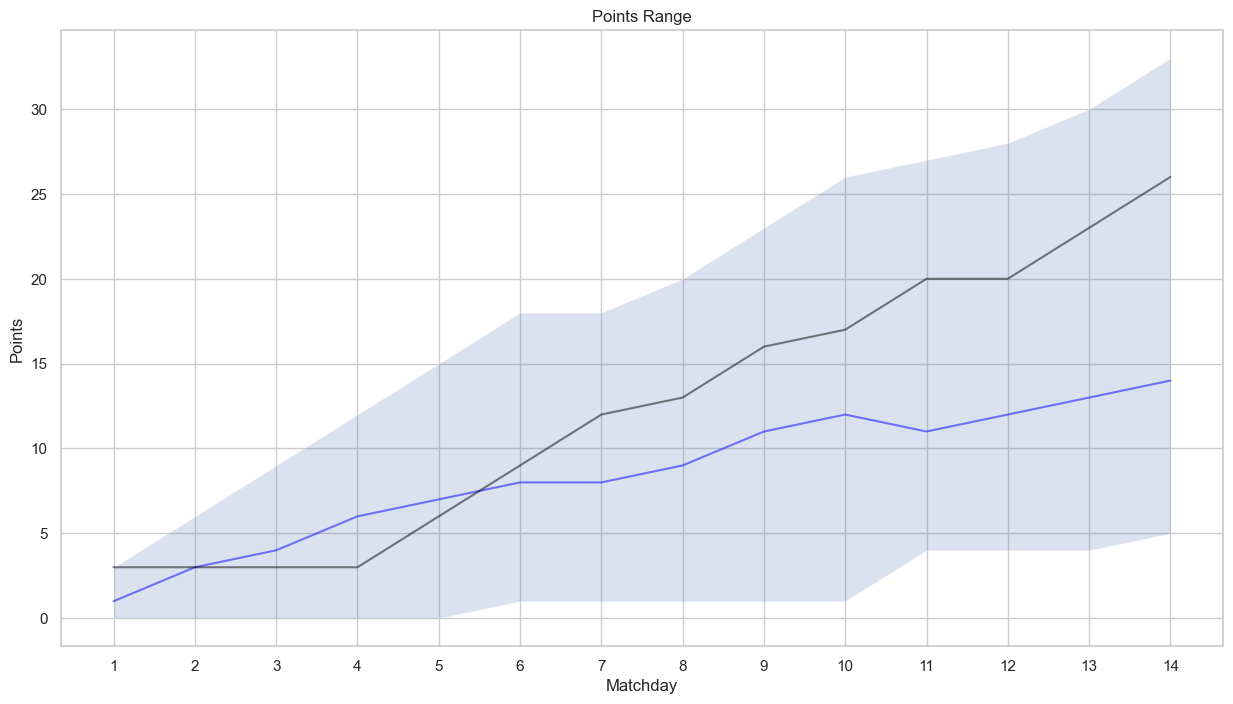

In [99]:
# plot points min and max in a filled line chart (fill_between)
# set style
sns.set_style("whitegrid")
# set size
plt.figure(figsize=(15, 8))
# plot min and max
plt.fill_between(df_min_max['matchday'], df_min_max['min'], df_min_max['max'], alpha=0.2)
# plot mean
plt.plot(df_min_max['matchday'], df_min_max['mean'], color='blue', alpha=0.5)
# plot newcastle
plt.plot(df_min_max['matchday'], df_min_max['newcastle'], color='black', alpha=0.5)
# plot median
# plt.plot(df_min_max['matchday'], df_min_max['median'], color='blue', alpha=0.5)
# set title
plt.title('Points Range')
# set y axis label
plt.ylabel('Points')
# set x axis label
plt.xlabel('Matchday')
# set x axis ticks
plt.xticks(df_min_max['matchday'])
# save plot
plt.savefig('points_range.png')
# show plot
plt.show()

In [136]:
# use the api to get 2022/23 results by change uri to 2022/23 season
api_key = os.environ['API_AUTH_KEY']

uri = 'http://api.football-data.org/v4/competitions/PL/matches?season=2022'
headers = { 'X-Auth-Token':  api_key}

r = requests.get(uri, headers=headers)
data = r.json()

# print(data)
# export data to json file
with open('2022.json', 'w') as outfile:
    json.dump(data, outfile)


df_2022 = pd.json_normalize(data, record_path='matches')

df_2022.describe()

# The data is trucated to 10 rows per matchday, so we need to get all the data for each matchday
# get the number of matches for each matchday
df_2022['matchday'].value_counts()


# df_2022['utcDate'] = pd.to_datetime(df_2022['utcDate'])
# sort by date
# df_2022 = df_2022.sort_values(by='utcDate', ascending=True).reset_index(drop=True)
# ename team names using club_names dict
# df_2022['homeTeam.shortName'] = df_2022['homeTeam.shortName'].replace(club_names)
# df_2022['awayTeam.shortName'] = df_2022['awayTeam.shortName'].replace(club_names)

# add score column
# df_2022['score'] = df_2022['score.fullTime.home'].astype(str) + '-' + df_2022['score.fullTime.away'].astype(str)

# keep only columns in keep_cols
# df_2022 = df_2022[keep_cols]

# apply function to get home_result and away_result
# df_2022['home_result'] = df.apply(get_result_home, axis=1)
# df_2022['away_result'] = df.apply(get_result_away, axis=1)

# df_2022.tail()

# df_2022['matchday'].unique()

# count the number of matches for each matchday
# df_2022['matchday'].value_counts()





matchday
1     10
29    10
22    10
23    10
24    10
25    10
26    10
27    10
28    10
30    10
2     10
31    10
32    10
33    10
34    10
35    10
36    10
37    10
21    10
20    10
7     10
19    10
3     10
4     10
5     10
6     10
8     10
9     10
10    10
11    10
12    10
13    10
14    10
15    10
16    10
17    10
18    10
38    10
Name: count, dtype: int64

In [123]:
# run points history function for 2022/23 season




# run function for each matchday
df_pts_2022 = create_points_history(df_2022, 'homeTeam.shortName', 'awayTeam.shortName', 'home_result', 'away_result', max_matchday)

# # loop over create_points_history function for each matchday from 1 to max_matchday, create a new column for each matchday
# for i in range(1, max_matchday_22 + 1):
#     df_pts_2022[i] = create_points_history(df_2022, 'homeTeam.shortName', 'awayTeam.shortName', 'home_result', 'away_result' , i)['points']

# drop the points column
# df_pts_2022 = df_pts_2022.drop(columns=['points'])

df_pts_2022.head(20)



,team,points
0,Crystal Palace,16
1,Fulham,22
2,Tottenham,26
3,Newcastle,18
4,Leeds,15
5,Bournemouth,13
6,Everton,34
7,Man United,16
8,Leicester,20
9,West Ham,24
